# Book Recommendation

Data:
https://www.kaggle.com/code/fahadmehfoooz/book-recommendation-system/input

Goal:
- popularity, content and collaborative recommendation systems
- use another libray as scikit-surprise because it is unmaintained and doesnt work anymore for python 3.12
- use one algorithm where I can use HPO

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from PIL import Image
import re
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_colwidth', None)
headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:97.0) Gecko/20100101 Firefox/97.0'}

### Data Overview

In [2]:
books_df = pd.read_csv("./data/books/Books.csv").set_index("ISBN")
books_df.head()

C:\Users\Eric User\AppData\Local\Temp\ipykernel_12032\2748821274.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv("./data/books/Books.csv").set_index("ISBN")


Book-Title  \
ISBN                                                                                                             
0195153448                                                                                 Classical Mythology   
0002005018                                                                                        Clara Callan   
0060973129                                                                                Decision in Normandy   
0374157065  Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It   
0393045218                                                                              The Mummies of Urumchi   

                     Book-Author Year-Of-Publication  \
ISBN                                                   
0195153448    Mark P. O. Morford                2002   
0002005018  Richard Bruce Wright                2001   
0060973129          Carlo D'Este                1991   
0374157065      Gina Bari Kolata                1999   
0393045218       E. J. W. Barber                1999   

                             Publisher  \
ISBN                                     
0195153448     Oxford University Press   
0002005018       HarperFlamingo Canada   
0060973129             HarperPerennial   
0374157065        Farrar Straus Giroux   
0393045218  W. W. Norton &amp; Company   

                                                             Image-URL-S  \
ISBN                                                                       
0195153448  http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg   
0002005018  http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg   
0060973129  http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg   
0374157065  http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg   
0393045218  http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg   

                                                             Image-URL-M  \
ISBN                                                                       
0195153448  http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg   
0002005018  http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg   
0060973129  http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg   
0374157065  http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg   
0393045218  http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg   

                                                             Image-URL-L  
ISBN                                                                      
0195153448  http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg  
0002005018  http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg  
0060973129  http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg  
0374157065  http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg  
0393045218  http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg

In [3]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271360 entries, 0195153448 to 0767409752
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Book-Title           271360 non-null  object
 1   Book-Author          271358 non-null  object
 2   Year-Of-Publication  271360 non-null  object
 3   Publisher            271358 non-null  object
 4   Image-URL-S          271360 non-null  object
 5   Image-URL-M          271360 non-null  object
 6   Image-URL-L          271357 non-null  object
dtypes: object(7)
memory usage: 16.6+ MB


Why is Year-Of-Publication not numerical?

In [4]:
books_df[~books_df['Year-Of-Publication'].apply(lambda x : str(x).isdigit())]

Book-Title  \
ISBN                                                                                                                      
078946697X         DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\";Michael Teitelbaum"   
2070426769                                     Peuple du ciel, suivi de 'Les Bergers\";Jean-Marie Gustave Le ClÃ?Â©zio"   
0789466953  DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\";James Buckley"   

           Book-Author Year-Of-Publication  \
ISBN                                         
078946697X        2000   DK Publishing Inc   
2070426769        2003           Gallimard   
0789466953        2000   DK Publishing Inc   

                                                               Publisher  \
ISBN                                                                       
078946697X  http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg   
2070426769  http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg   
0789466953  http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg   

                                                             Image-URL-S  \
ISBN                                                                       
078946697X  http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg   
2070426769  http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg   
0789466953  http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg   

                                                             Image-URL-M  \
ISBN                                                                       
078946697X  http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg   
2070426769  http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg   
0789466953  http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg   

           Image-URL-L  
ISBN                    
078946697X         NaN  
2070426769         NaN  
0789466953         NaN

In [5]:
books_df.describe()

Book-Title      Book-Author  Year-Of-Publication  Publisher  \
count           271360           271358               271360     271358   
unique          242135           102022                  202      16807   
top     Selected Poems  Agatha Christie                 2002  Harlequin   
freq                27              632                13903       7535   

                                                         Image-URL-S  \
count                                                         271360   
unique                                                        271044   
top     http://images.amazon.com/images/P/185326119X.01.THUMBZZZ.jpg   
freq                                                               2   

                                                         Image-URL-M  \
count                                                         271360   
unique                                                        271044   
top     http://images.amazon.com/images/P/185326119X.01.MZZZZZZZ.jpg   
freq                                                               2   

                                                         Image-URL-L  
count                                                         271357  
unique                                                        271041  
top     http://images.amazon.com/images/P/225307649X.01.LZZZZZZZ.jpg  
freq                                                               2

In [6]:
users_df = pd.read_csv("./data/books/Users.csv").set_index("User-ID")
users_df.head()

Location   Age
User-ID                                          
1                        nyc, new york, usa   NaN
2                 stockton, california, usa  18.0
3           moscow, yukon territory, russia   NaN
4                 porto, v.n.gaia, portugal  17.0
5        farnborough, hants, united kingdom   NaN

In [7]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278858 entries, 1 to 278858
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Location  278858 non-null  object 
 1   Age       168096 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.4+ MB


In [8]:
users_df.describe()

Age
count  168096.000000
mean       34.751434
std        14.428097
min         0.000000
25%        24.000000
50%        32.000000
75%        44.000000
max       244.000000

Users with Age 0?

In [9]:
users_df[users_df['Age'] < 12]

Location   Age
User-ID                                                     
220                           bogota, bogota, colombia   0.0
470                         indianapolis, indiana, usa   0.0
562      adfdaf, australian capital territory, albania   0.0
613                                ankara, n/a, turkey   1.0
671                       jeddah, jeddah, saudi arabia   1.0
...                                                ...   ...
277405                     bismarck, north dakota, usa  10.0
277909                           phoenix, arizona, usa   2.0
278266                    matale, sri lanka, sri lanka   7.0
278524                                  kansas city, ,  10.0
278752                     london, nova scotia, canada   9.0

[1274 rows x 2 columns]

In [10]:
users_df.describe(include="object")

Location
count                            278858
unique                            57339
top     london, england, united kingdom
freq                               2506

In [11]:
ratings_df = pd.read_csv("./data/books/Ratings.csv", dtype={"User-ID" : str})
# pivoting too large datasets kills my RAM -> for a real world example we could cluster and calculate for different chunks
ratings_df.head()

User-ID        ISBN  Book-Rating
0  276725  034545104X            0
1  276726  0155061224            5
2  276727  0446520802            0
3  276729  052165615X            3
4  276729  0521795028            6

In [12]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  object
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 26.3+ MB


In [13]:
ratings_df.describe()

Book-Rating
count  1.149780e+06
mean   2.866950e+00
std    3.854184e+00
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    7.000000e+00
max    1.000000e+01

In [14]:
print("Books Shape: " ,books_df.shape )
print("Users Shape: " ,users_df.shape )
print("Ratings Shape: " ,ratings_df.shape )
print("\nNull values in DFs:")
print(f"Books:\n{books_df.isnull().sum()}\n")
print(f"Users:\n{users_df.isnull().sum()}\n")
print(f"Ratings:\n{ratings_df.isnull().sum()}")

Books Shape:  (271360, 7)
Users Shape:  (278858, 2)
Ratings Shape:  (1149780, 3)

Null values in DFs:
Books:
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Users:
Location         0
Age         110762
dtype: int64

Ratings:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


### Inferences:
- Book Dataframe
  - we know that the **Year-Of-Publication** should be of numerical type; however, the year data contains non-numeric values
  - it's evident that the CSV file is corrupted at three rows, which results in moved columns

- Users Dataframe
  - there are over 1200 users with ages less than ten, users with age zero, and users with no specified age
  - the majority of our users are in their 30s and from England

- Ratings Dataframe
  - contains ratings between 0 and 10
  - as given in our dataset description, users can rate explicitly from 1 to 10 or implicitly with a rating of 0, indicating that a user purchased the book but didn't rate it

## Data Cleaning and Transformations

Clean Book Data

In [15]:
# clean corrupted rows
corrupt_df = books_df[~books_df['Year-Of-Publication'].apply(lambda x : str(x).isdigit())]
clean_book_df = pd.DataFrame(list(corrupt_df['Book-Title'].str.replace('\\', '').str.replace('"', '').str.split(";").values), columns=['Book-Title', 'Book-Author'])
corrupt_df = corrupt_df.shift(axis=1)
corrupt_df['Book-Title'] = clean_book_df['Book-Title'].values
corrupt_df['Book-Author'] = clean_book_df['Book-Author'].values
books_df.update(corrupt_df)
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype(int)
books_df[["Book-Title", "Book-Author", "Publisher"]] = books_df[["Book-Title", "Book-Author", "Publisher"]].apply(lambda x: x.str.strip())

In [16]:
# Do we have duplicates? Yes
books_df[books_df.duplicated(keep=False)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 630 entries, 042511774X to 039304632x
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Book-Title           630 non-null    object
 1   Book-Author          630 non-null    object
 2   Year-Of-Publication  630 non-null    int32 
 3   Publisher            630 non-null    object
 4   Image-URL-S          630 non-null    object
 5   Image-URL-M          630 non-null    object
 6   Image-URL-L          630 non-null    object
dtypes: int32(1), object(6)
memory usage: 36.9+ KB


In [17]:
# ISBNs are case sensitive in our data
books_df[books_df['Book-Title'] == "Politically Correct Bedtime Stories: Modern Tales for Our Life and Times"]

Book-Title  \
ISBN                                                                                   
002542730X  Politically Correct Bedtime Stories: Modern Tales for Our Life and Times   
002542730x  Politically Correct Bedtime Stories: Modern Tales for Our Life and Times   

                  Book-Author  Year-Of-Publication                  Publisher  \
ISBN                                                                            
002542730X  James Finn Garner                 1994  John Wiley &amp; Sons Inc   
002542730x  James Finn Garner                 1994  John Wiley &amp; Sons Inc   

                                                             Image-URL-S  \
ISBN                                                                       
002542730X  http://images.amazon.com/images/P/002542730X.01.THUMBZZZ.jpg   
002542730x  http://images.amazon.com/images/P/002542730X.01.THUMBZZZ.jpg   

                                                             Image-URL-M  \
ISBN                                                                       
002542730X  http://images.amazon.com/images/P/002542730X.01.MZZZZZZZ.jpg   
002542730x  http://images.amazon.com/images/P/002542730X.01.MZZZZZZZ.jpg   

                                                             Image-URL-L  
ISBN                                                                      
002542730X  http://images.amazon.com/images/P/002542730X.01.LZZZZZZZ.jpg  
002542730x  http://images.amazon.com/images/P/002542730X.01.LZZZZZZZ.jpg

In [18]:
books_df = books_df.reset_index()
books_df['ISBN'] = books_df['ISBN'].apply(lambda x : re.sub(r'[^a-zA-Z0-9]', '', x.upper()))
print(f"We had: {books_df.duplicated().sum()} duplicates!")
books_df = books_df.drop_duplicates().set_index("ISBN")
books_df.info()

We had: 314 duplicates!
<class 'pandas.core.frame.DataFrame'>
Index: 271046 entries, 0195153448 to 0767409752
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Book-Title           271046 non-null  object
 1   Book-Author          271044 non-null  object
 2   Year-Of-Publication  271046 non-null  int32 
 3   Publisher            271044 non-null  object
 4   Image-URL-S          271046 non-null  object
 5   Image-URL-M          271046 non-null  object
 6   Image-URL-L          271046 non-null  object
dtypes: int32(1), object(6)
memory usage: 15.5+ MB


In [19]:
books_df[books_df['Book-Author'].isna() | books_df['Publisher'].isna()]

Book-Title  \
ISBN                                                                   
0751352497                                  A+ Quiz Masters:01 Earth   
193169656X                                               Tyrant Moon   
1931696993                                           Finders Keepers   
9627982032  The Credit Suisse Guide to Managing Your Personal Wealth   

                Book-Author  Year-Of-Publication  \
ISBN                                               
0751352497              NaN                 1999   
193169656X  Elaine Corvidae                 2002   
1931696993  Linnea Sinclair                 2001   
9627982032              NaN                 1995   

                                 Publisher  \
ISBN                                         
0751352497              Dorling Kindersley   
193169656X                             NaN   
1931696993                             NaN   
9627982032  Edinburgh Financial Publishing   

                                                             Image-URL-S  \
ISBN                                                                       
0751352497  http://images.amazon.com/images/P/0751352497.01.THUMBZZZ.jpg   
193169656X  http://images.amazon.com/images/P/193169656X.01.THUMBZZZ.jpg   
1931696993  http://images.amazon.com/images/P/1931696993.01.THUMBZZZ.jpg   
9627982032  http://images.amazon.com/images/P/9627982032.01.THUMBZZZ.jpg   

                                                             Image-URL-M  \
ISBN                                                                       
0751352497  http://images.amazon.com/images/P/0751352497.01.MZZZZZZZ.jpg   
193169656X  http://images.amazon.com/images/P/193169656X.01.MZZZZZZZ.jpg   
1931696993  http://images.amazon.com/images/P/1931696993.01.MZZZZZZZ.jpg   
9627982032  http://images.amazon.com/images/P/9627982032.01.MZZZZZZZ.jpg   

                                                             Image-URL-L  
ISBN                                                                      
0751352497  http://images.amazon.com/images/P/0751352497.01.LZZZZZZZ.jpg  
193169656X  http://images.amazon.com/images/P/193169656X.01.LZZZZZZZ.jpg  
1931696993  http://images.amazon.com/images/P/1931696993.01.LZZZZZZZ.jpg  
9627982032  http://images.amazon.com/images/P/9627982032.01.LZZZZZZZ.jpg

In [20]:
# we have only 2 missing authors and publishers, we can complete this by hand
books_df.loc['0751352497', 'Book-Author'] = 'Unknown'
books_df.loc['9627982032', 'Book-Author'] = 'Credit Suisse'
books_df.loc['193169656X', 'Publisher'] = 'MUNDANIA PR LLC'
books_df.loc['1931696993', 'Publisher'] = 'NovelBooks'

Clean and Transform Users Data

In [21]:
# split user location column into three different columns, city, state, country
location_df = pd.DataFrame([[val.strip() for val in x[-3:]] for x in list(users_df['Location'].str.lower().str.split(",").values)], columns=['City', 'State', 'Country'])
location_df['User-ID'] = location_df.index + 1
location_df = location_df.set_index('User-ID')
location_df[['City', 'State', 'Country']] = location_df[['City', 'State', 'Country']].replace({'n/a': None, '': None})
users_df = users_df.merge(location_df, how="inner", on="User-ID")
users_df['Dirty-Location'] = users_df['Location'].apply(lambda x: len(x.split(", ")) != 3)
users_df
# interesting step would be to do get the latitude and longitude (with geopy) and do geoclustering, but would be overkill for this project

Location   Age         City  \
User-ID                                                          
1                        nyc, new york, usa   NaN          nyc   
2                 stockton, california, usa  18.0     stockton   
3           moscow, yukon territory, russia   NaN       moscow   
4                 porto, v.n.gaia, portugal  17.0        porto   
5        farnborough, hants, united kingdom   NaN  farnborough   
...                                     ...   ...          ...   
278854                portland, oregon, usa   NaN     portland   
278855   tacoma, washington, united kingdom  50.0       tacoma   
278856            brampton, ontario, canada   NaN     brampton   
278857            knoxville, tennessee, usa   NaN    knoxville   
278858                 dublin, n/a, ireland   NaN       dublin   

                   State         Country  Dirty-Location  
User-ID                                                   
1               new york             usa           False  
2             california             usa           False  
3        yukon territory          russia           False  
4               v.n.gaia        portugal           False  
5                  hants  united kingdom           False  
...                  ...             ...             ...  
278854            oregon             usa           False  
278855        washington  united kingdom           False  
278856           ontario          canada           False  
278857         tennessee             usa           False  
278858              None         ireland           False  

[278858 rows x 6 columns]

Clean and Transform Rating Data

In [22]:
ratings_df['ISBN'] = ratings_df['ISBN'].apply(lambda x : re.sub(r'[^a-zA-Z0-9]', '', x.upper()))
ratings_df = ratings_df[ratings_df['ISBN'].isin(books_df.index)]  # filter isbns out which arent in our books df 
ratings_df = ratings_df.drop_duplicates() # Drop duplicate ratings, particularly with implicit ratings, where occurrences might arise if a user purchases a book multiple times.
# we may address implicit ratings at a later stage, once we've determined our approach for recommendations

## Feature Engineering

In [23]:
# count of unique books purchased per customer, we only have unique books and not overall books
unique_books_per_customer = ratings_df.groupby("User-ID")['ISBN'].nunique().reset_index()
unique_books_per_customer.columns = ['User-ID', 'Unique-Books-Bought']
unique_books_per_customer['User-ID'] = unique_books_per_customer['User-ID'].astype(int)

users_df = users_df.merge(unique_books_per_customer, on='User-ID', how='left').set_index("User-ID")
users_df['Unique-Books-Bought'] = users_df['Unique-Books-Bought'].fillna(0)
users_df.head()

Location   Age         City  \
User-ID                                                          
1                        nyc, new york, usa   NaN          nyc   
2                 stockton, california, usa  18.0     stockton   
3           moscow, yukon territory, russia   NaN       moscow   
4                 porto, v.n.gaia, portugal  17.0        porto   
5        farnborough, hants, united kingdom   NaN  farnborough   

                   State         Country  Dirty-Location  Unique-Books-Bought  
User-ID                                                                        
1               new york             usa           False                  0.0  
2             california             usa           False                  1.0  
3        yukon territory          russia           False                  0.0  
4               v.n.gaia        portugal           False                  0.0  
5                  hants  united kingdom           False                  0.0

In [24]:
# rating count of a book
ratings_df_no_implicit = ratings_df[ratings_df['Book-Rating'] > 0 ]

ratings_per_book = ratings_df_no_implicit.groupby('ISBN')['ISBN'].count()
ratings_per_book_df = pd.DataFrame(ratings_per_book).rename(columns = {'ISBN' : 'Book-Rating-Count'}).reset_index()
books_df = books_df.merge(ratings_per_book_df, on='ISBN', how='left').set_index("ISBN")
books_df['Book-Rating-Count'] = books_df['Book-Rating-Count'].fillna(0)

mean_per_book = ratings_df_no_implicit.groupby('ISBN')['Book-Rating'].mean()
mean_per_book_df = pd.DataFrame(mean_per_book).rename(columns = {'Book-Rating' : 'Book-Rating-Average'}).reset_index()
books_df = books_df.merge(mean_per_book_df, on='ISBN', how='left').set_index("ISBN")
books_df['Book-Rating-Average'] = books_df['Book-Rating-Average'].fillna(0)

books_df.sort_values(by='Book-Rating-Count', ascending=False).head(3)

Book-Title   Book-Author  Year-Of-Publication  \
ISBN                                                                       
0316666343  The Lovely Bones: A Novel  Alice Sebold                 2002   
0971880107                Wild Animus  Rich Shapero                 2004   
0385504209          The Da Vinci Code     Dan Brown                 2003   

                Publisher  \
ISBN                        
0316666343  Little, Brown   
0971880107        Too Far   
0385504209      Doubleday   

                                                             Image-URL-S  \
ISBN                                                                       
0316666343  http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg   
0971880107  http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg   
0385504209  http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg   

                                                             Image-URL-M  \
ISBN                                                                       
0316666343  http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg   
0971880107  http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg   
0385504209  http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg   

                                                             Image-URL-L  \
ISBN                                                                       
0316666343  http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg   
0971880107  http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg   
0385504209  http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg   

            Book-Rating-Count  Book-Rating-Average  
ISBN                                                
0316666343              707.0             8.185290  
0971880107              581.0             4.390706  
0385504209              488.0             8.426230

## Data Analysis

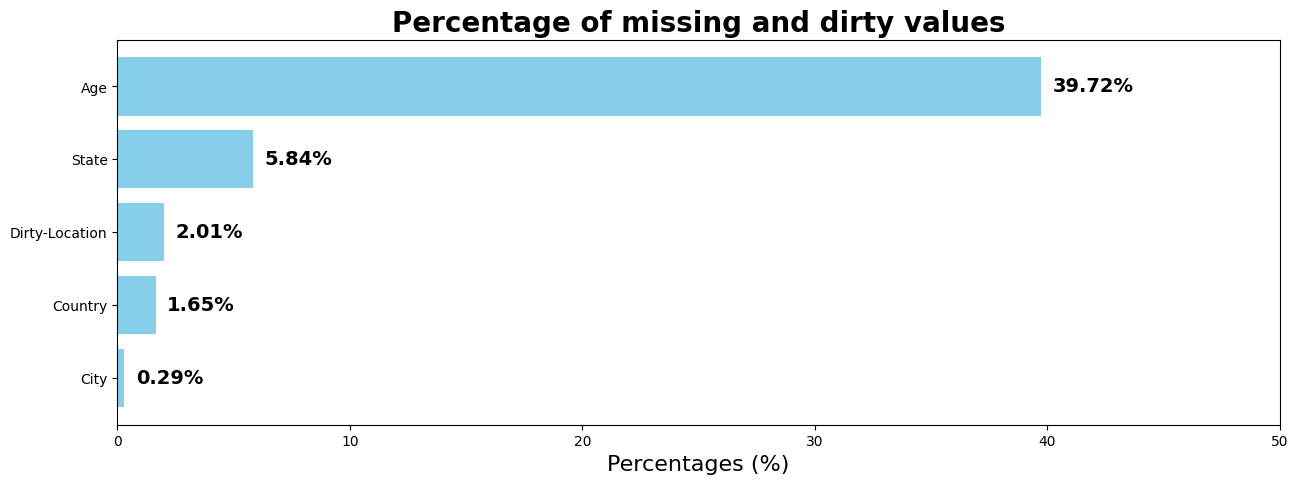

In [25]:
# plot with percentage of dirty and missing values in user data
# Calculating the percentage of missing values for each column
missing_data = users_df.isnull().sum()
missing_data["Dirty-Location"] = users_df[users_df["Dirty-Location"] == True]["Dirty-Location"].count()
missing_percentage = (missing_data[missing_data > 0] / users_df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(missing_percentage.index, missing_percentage, color='skyblue')
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=14, color='black')
ax.set_xlim([0, 50])

plt.title("Percentage of missing and dirty values", fontweight='bold', fontsize=20)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

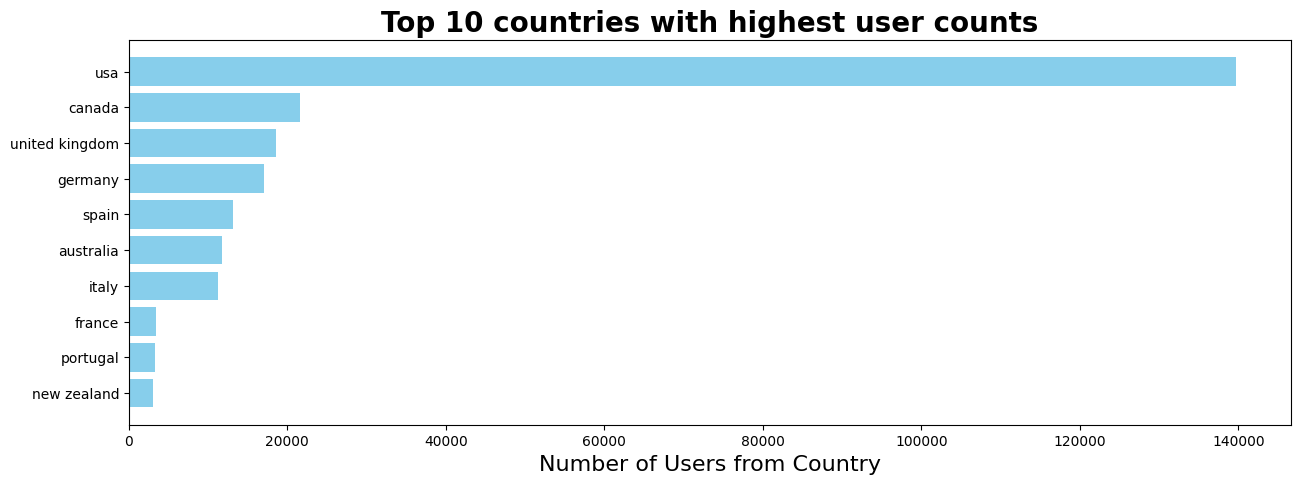

In [26]:
top_10_countries = users_df["Country"].value_counts().head(10).sort_values()

fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(top_10_countries.index, top_10_countries, color='skyblue')
plt.title("Top 10 countries with highest user counts", fontweight='bold', fontsize=20)
plt.xlabel('Number of Users from Country', fontsize=16)
plt.show()

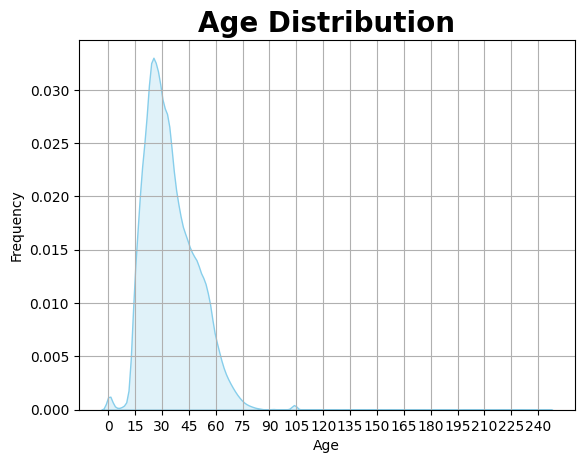

In [27]:
# plot with user age distribution
age_data = users_df['Age'].dropna()

sns.kdeplot(age_data, fill=True, color='skyblue')
plt.xticks(np.arange(0, age_data.max()+1, 15))
plt.title('Age Distribution', fontweight='bold', fontsize=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

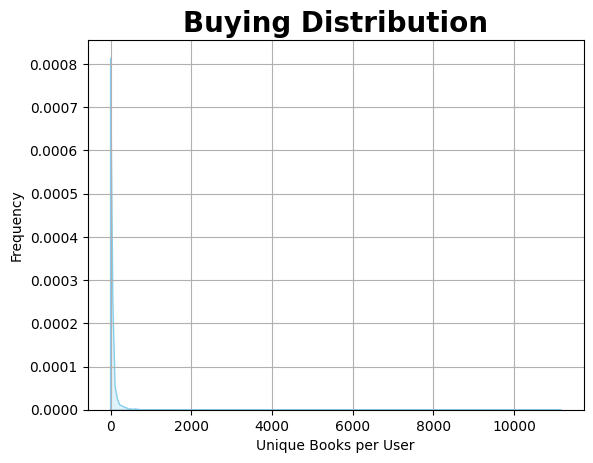

In [28]:
# plot with user bought distribution
buying_data = users_df['Unique-Books-Bought']

sns.kdeplot(buying_data, fill=True, color='skyblue')
plt.title('Buying Distribution', fontweight='bold', fontsize=20)
plt.xlabel('Unique Books per User')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

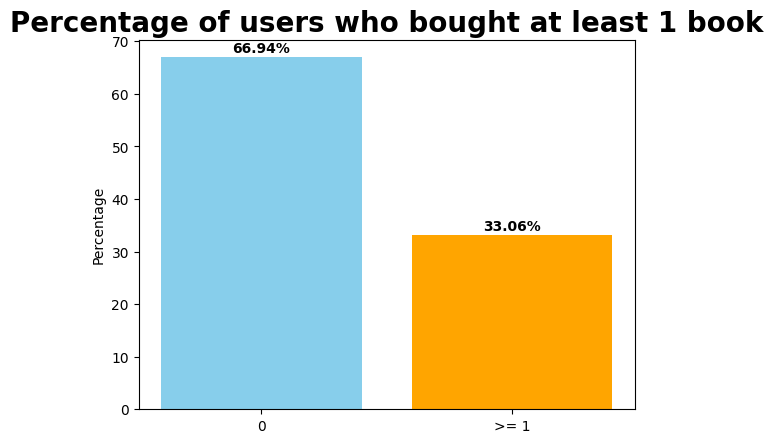

In [29]:
at_least_one_book = users_df[users_df['Unique-Books-Bought'] >= 1]['Unique-Books-Bought'].count() / len(users_df) * 100
zero_books = users_df[users_df['Unique-Books-Bought'] == 0]['Unique-Books-Bought'].count() / len(users_df) * 100


plt.bar(['0', '>= 1'], [zero_books, at_least_one_book], color=['skyblue', 'orange'])
for i, percentage in enumerate([zero_books, at_least_one_book]):
    plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', fontweight='bold', fontsize=10, color='black')
plt.title('Percentage of users who bought at least 1 book', fontweight='bold', fontsize=20)
plt.ylabel('Percentage')
plt.show()

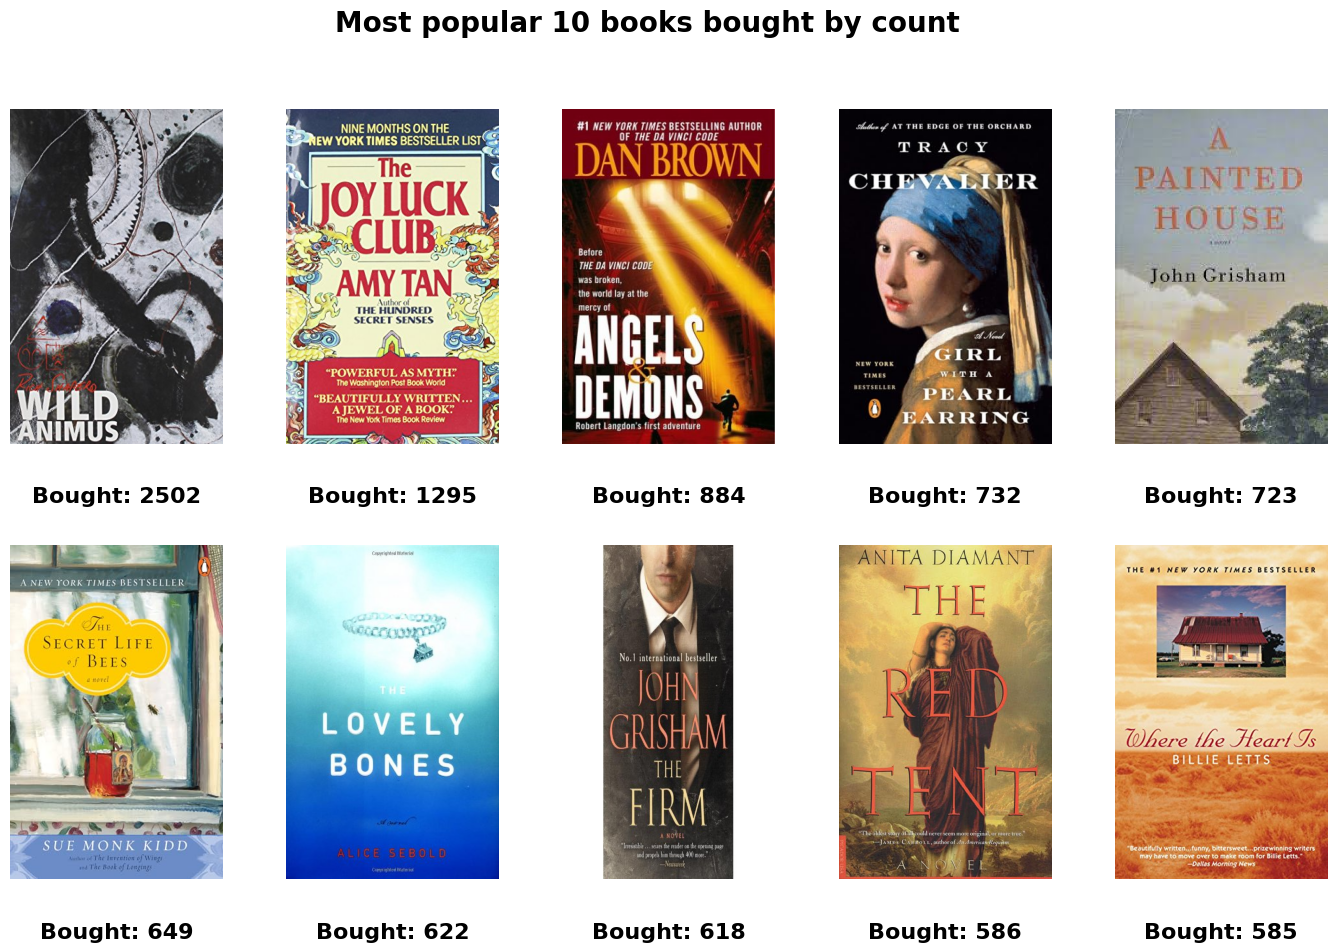

In [30]:
# plot with top 10 most frequent books bought
top_10_isbns = ratings_df["ISBN"].value_counts().head(20)
top_10_books = books_df[books_df.index.isin(top_10_isbns.index.tolist())].head(10).reset_index()

fig, ax = plt.subplots(2, 5, figsize=(17,10))
fig.suptitle("Most popular 10 books bought by count", fontweight='bold', fontsize=20)

for i, row in top_10_books.iterrows():
    url = row["Image-URL-L"]
    img = Image.open(requests.get(url, headers=headers, stream = True).raw)
    ax[i // 5, i % 5].imshow(img, aspect='auto')
    ax[i // 5, i % 5].axis("off")
    ax[i // 5, i % 5].set_title(f"Bought: {top_10_isbns.iloc[i]}", y=-0.2, fontweight='bold', fontsize=16)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

## Recommendation Systems

### Filtering by popularity
- general popularity based approach
- not sensitive to interests and tastes of particular user
- metric to score or rate a book is taken from IMDBs weighting rating (true Bayesian estimate) given as:  
```wr = (v / (v + m) * R) + (m / (v + m) * C)```  
    - v -> number of votes
    - m -> minimum votes required
    - R -> average rating
    - C -> mean vote across all ratings


In [31]:
def weighted_rating(x, m, C):
    v = x['Book-Rating-Count']
    R = x['Book-Rating-Average']
    # Calculation based on the IMDB formula
    return (v / (v+m) * R) + (m / (m+v) * C)

In [32]:
df = ratings_df[ratings_df['Book-Rating'] > 0] # remove implicit ratings otherwise they will skew the mean
C = df['Book-Rating'].mean()
m = books_df['Book-Rating-Count'].quantile(0.9) # 90% quantile is cutoff -> recommended books must have more votes than 90% of the other books
q_books = books_df[books_df['Book-Rating-Count'] >= m]
print(f"Minimum Ratings to be in Top: {m}")
print(f"Across Document rating: {C}")
print(f"We have {q_books.shape[0]} books in our selection.")
q_books['Score'] = q_books.apply(weighted_rating, args=(m, C), axis=1)
q_books = q_books.sort_values('Score', ascending=False)
q_books.head(3)

Minimum Ratings to be in Top: 3.0
Across Document rating: 7.626801970710164
We have 27828 books in our selection.


C:\Users\Eric User\AppData\Local\Temp\ipykernel_12032\1332872065.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_books['Score'] = q_books.apply(weighted_rating, args=(m, C), axis=1)


Book-Title  \
ISBN                                                                
0439425220  Harry Potter and the Chamber of Secrets Postcard Book   
0618002235         The Two Towers (The Lord of the Rings, Part 2)   
0836213319                           Dilbert: A Book of Postcards   

                 Book-Author  Year-Of-Publication                 Publisher  \
ISBN                                                                          
0439425220     J. K. Rowling                 2002                Scholastic   
0618002235  J. R. R. Tolkien                 1999  Houghton Mifflin Company   
0836213319       Scott Adams                 1996        Andrews McMeel Pub   

                                                             Image-URL-S  \
ISBN                                                                       
0439425220  http://images.amazon.com/images/P/0439425220.01.THUMBZZZ.jpg   
0618002235  http://images.amazon.com/images/P/0618002235.01.THUMBZZZ.jpg   
0836213319  http://images.amazon.com/images/P/0836213319.01.THUMBZZZ.jpg   

                                                             Image-URL-M  \
ISBN                                                                       
0439425220  http://images.amazon.com/images/P/0439425220.01.MZZZZZZZ.jpg   
0618002235  http://images.amazon.com/images/P/0618002235.01.MZZZZZZZ.jpg   
0836213319  http://images.amazon.com/images/P/0836213319.01.MZZZZZZZ.jpg   

                                                             Image-URL-L  \
ISBN                                                                       
0439425220  http://images.amazon.com/images/P/0439425220.01.LZZZZZZZ.jpg   
0618002235  http://images.amazon.com/images/P/0618002235.01.LZZZZZZZ.jpg   
0836213319  http://images.amazon.com/images/P/0836213319.01.LZZZZZZZ.jpg   

            Book-Rating-Count  Book-Rating-Average     Score  
ISBN                                                          
0439425220               23.0             9.869565  9.610785  
0618002235               25.0             9.720000  9.495729  
0836213319               13.0             9.923077  9.492525

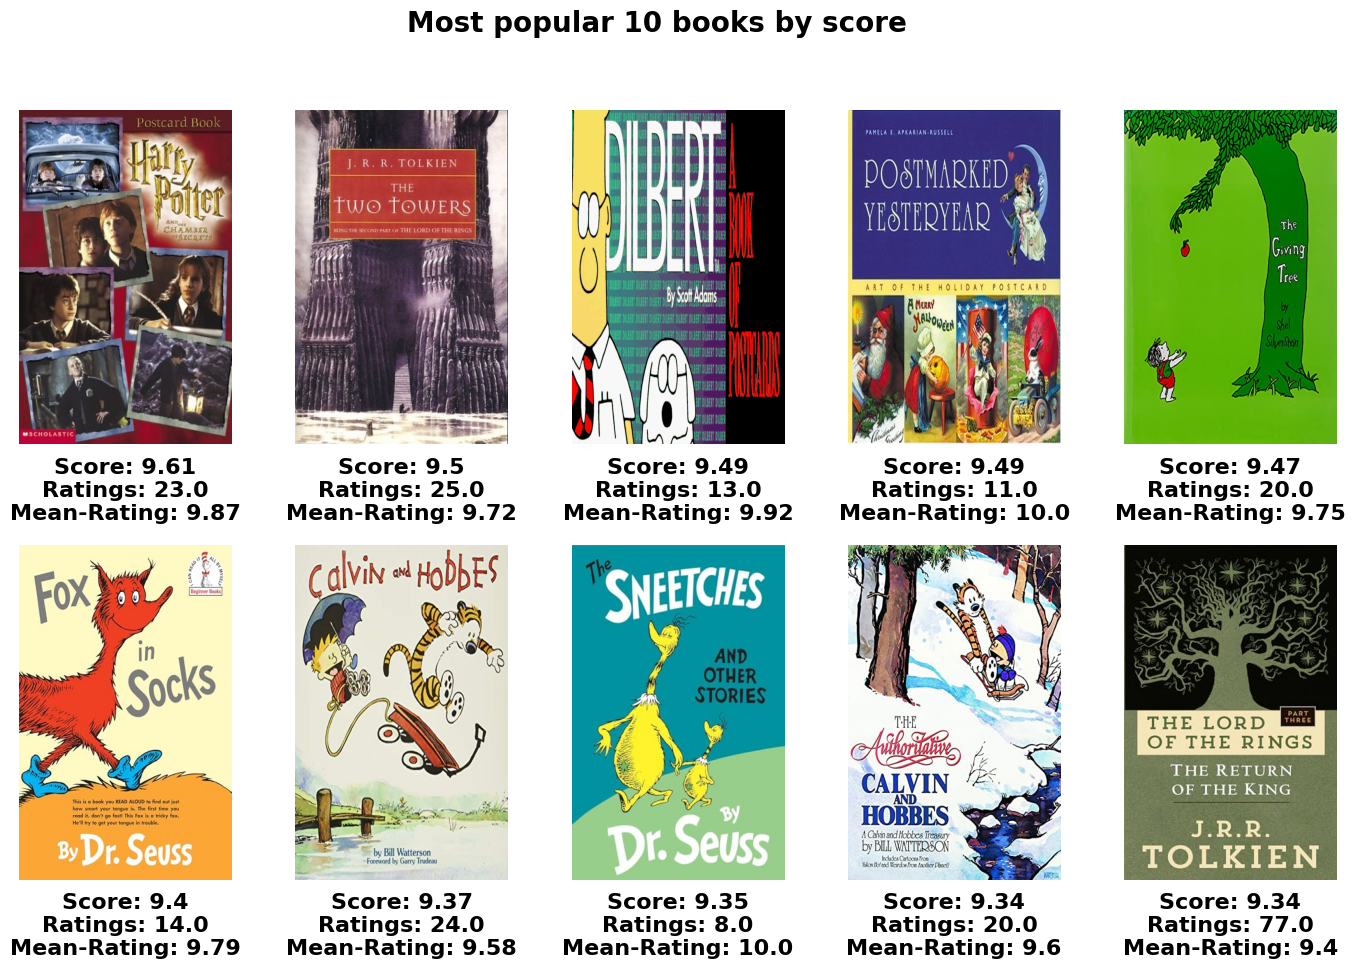

In [33]:
fig, ax = plt.subplots(2, 5, figsize=(17,10))
fig.suptitle("Most popular 10 books by score", fontweight='bold', fontsize=20)

for i, row in q_books.head(10).reset_index().iterrows():
    url = row["Image-URL-L"]
    img = Image.open(requests.get(url, headers=headers, stream = True).raw)
    ax[i // 5, i % 5].imshow(img, aspect='auto')
    ax[i // 5, i % 5].axis("off")
    ax[i // 5, i % 5].set_title((f"Score: {round(row['Score'], 2)}\n"
                                f"Ratings: {row['Book-Rating-Count']}\n"
                                f"Mean-Rating: {round(row['Book-Rating-Average'], 2)}"), y=-0.25, fontweight='bold', fontsize=16)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

### Content Based Filtering
- decent for finding similar items based on author or title
- limited applicability to our dataset due to lack of columns like descriptions
- memory intensive

In [88]:
# content based approach with tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

df = books_df.head(20000).copy().reset_index() # need to take head because I cant allocate much more memory
df['Text'] = df['Book-Title'] + ' ' + df['Book-Author']
tfidf = TfidfVectorizer(stop_words='english') # we dont use CountVectorizer, because tfidf down weights often used words
tfidf_matrix = tfidf.fit_transform(df['Text'])
# Compute the cosine similarity matrix
# After TF-IDF calculating the dot product gives us directly the cosine simularity, thats why we can use linear_kernel instead of cosine_simularity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df.index, index=df['Text']) # reverse mapping of row numbers to 
print(f"Books: {tfidf_matrix.shape[0]}\nDifferent Words: {tfidf_matrix.shape[1]}")

Books: 20000
Different Words: 24157


In [89]:
def get_recommendations(title, k, cosine_sim, df):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores[1:k]]  # exclude 0, because its the search term
    return df['Text'].iloc[book_indices]

In [90]:
get_recommendations("Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) J. K. Rowling", 5, cosine_sim, df) # good result

2809    Harry Potter and the Sorcerer's Stone (Book 1) J. K. Rowling
9025    Harry Potter and the Sorcerer's Stone (Book 1) J. K. Rowling
5431      Harry Potter and the Goblet of Fire (Book 4) J. K. Rowling
6931      Harry Potter and the Goblet of Fire (Book 4) J. K. Rowling
Name: Text, dtype: object

In [91]:
get_recommendations("The Mummies of Urumchi E. J. W. Barber", 5, cosine_sim, df) # bad result

16208                                                                                 Catkin Antonia Barber
19570    The Wealthy Barber: Everyone's Commonsense Guide to Becoming Financially Independent David Chilton
0                                                                    Classical Mythology Mark P. O. Morford
1                                                                         Clara Callan Richard Bruce Wright
Name: Text, dtype: object

## User-Based Collaborative Filtering
- Cosine Similarity vs SVD vs NMF 
- Scalability issue: limited to the first 40000 ratings
- Handling implicit ratings
- Impact of sparsity: deterioration in predicted ratings
- Personalized recommendations

In [24]:
df = ratings_df[ratings_df['Book-Rating'] > 0].head(40000) # remove implicit ratings they dont help us to recommend by rank except we guess a mean rating or something
user_item_pivot_matrix_df = df.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating', fill_value=0)
user_item_pivot_matrix_df.head()

ISBN     0001046438  000104687X  0001047213  0001047973  0001048082  \
User-ID                                                               
10001           0.0         0.0         0.0         0.0         0.0   
10003           0.0         0.0         0.0         0.0         0.0   
10008           0.0         0.0         0.0         0.0         0.0   
10009           0.0         0.0         0.0         0.0         0.0   
1003            0.0         0.0         0.0         0.0         0.0   

ISBN     0001360469  0001374869  000160418X  0001939203  0001944711  ...  \
User-ID                                                              ...   
10001           0.0         0.0         0.0         0.0         0.0  ...   
10003           0.0         0.0         0.0         0.0         0.0  ...   
10008           0.0         0.0         0.0         0.0         0.0  ...   
10009           0.0         0.0         0.0         0.0         0.0  ...   
1003            0.0         0.0         0.0         0.0         0.0  ...   

ISBN     999750805X  9997519086  9997555635  B0000633PU  B00006CRTE  \
User-ID                                                               
10001           0.0         0.0         0.0         0.0         0.0   
10003           0.0         0.0         0.0         0.0         0.0   
10008           0.0         0.0         0.0         0.0         0.0   
10009           0.0         0.0         0.0         0.0         0.0   
1003            0.0         0.0         0.0         0.0         0.0   

ISBN     B00007MF56  B0000A2U93  B0000DAPP1  B0000DYXID  B0001GMSV2  
User-ID                                                              
10001           0.0         0.0         0.0         0.0         0.0  
10003           0.0         0.0         0.0         0.0         0.0  
10008           0.0         0.0         0.0         0.0         0.0  
10009           0.0         0.0         0.0         0.0         0.0  
1003            0.0         0.0         0.0         0.0         0.0  

[5 rows x 28141 columns]

In [93]:
# user_id is the real user_id and not the row number in the pivot matrix
def for_user_find_top_n_isbns_and_top_k_similar_users(user_id : str, k: int, n: int, sorted_similarities: list[list[tuple[int, float]]], user_item_pivot_matrix_df: pd.DataFrame, output: bool = False):
    try:
        user_row = user_item_pivot_matrix_df.index.get_loc(user_id)
    except:
        print("User ID doesn't exist.")
        return
        
    user_similarities = sorted_similarities[user_row]

    top_k_users = [user for user in user_similarities[1:k] if round(user[1], 5) > 0]
    sum_similarities = sum(similarity for _, similarity in top_k_users)
    if output and len(top_k_users) < k:
        print(f"User has less than k users with common books bought. Only {len(top_k_users)} with common books.")
        
    isbn_means = dict()  # safe weighted mean for each isbn
    for similar_user_row_number, similarity_score in top_k_users:
        similar_user_ratings = user_item_pivot_matrix_df.iloc[similar_user_row_number]
        for isbn, rating in similar_user_ratings.items():
            isbn_means[isbn] = isbn_means.get(isbn, 0) + (rating * (similarity_score / sum_similarities))

    # Sort ISBN means by value and get the top n
    top_n_isbns = sorted(isbn_means.items(), key=lambda x: x[1], reverse=True)[:n]

    return [(user_item_pivot_matrix_df.iloc[row_num].name, sim) for row_num, sim in top_k_users], top_n_isbns

In [94]:
def calculate_rmse_for_u_users_for_n_isbns_over_top_k_users(u: int, k: int, n: int, sorted_similarities: list[list[tuple[int, float]]], user_item_pivot_matrix_df: pd.DataFrame):
    rmse_list = []
    
    for user_id in user_item_pivot_matrix_df.head(u).index:
        _, top_n_isbns = for_user_find_top_n_isbns_and_top_k_similar_users(user_id, k, n, sorted_similarities, user_item_pivot_matrix_df)
        if len(top_n_isbns) == 0:
            continue
        predicted_ratings = []
        actual_ratings = []
        
        for isbn, predicted_rating in top_n_isbns:
            actual_rating = user_item_pivot_matrix_df.loc[user_id, isbn]
            if actual_rating > 0:
                predicted_ratings.append(predicted_rating)
                actual_ratings.append(actual_rating)
        
        if predicted_ratings:
            rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
            rmse_list.append(rmse)
            
    return sum(rmse_list) / len(rmse_list)

In [95]:
def sort_similarities(correlation_matrix):
    sorted_similarities= []
    for row in correlation_matrix:
        sorted_indices = np.argsort(row)[::-1]
        sorted_values = row[sorted_indices]
        sorted_similarities.append(list(zip(sorted_indices, sorted_values)))
    return sorted_similarities

### Cosine Similarity vs SVD vs NMF
- cold start problem
- not everything by other users is rated -> we predict wrong values
- neglecting niche items, has bias

#### Cosine Similarity

In [96]:
user_similarity_matrix = cosine_similarity(user_item_pivot_matrix_df)
sorted_similarities_cos = sort_similarities(user_similarity_matrix)

In [97]:
user_id = "10001"
top_users, top_isbns = for_user_find_top_n_isbns_and_top_k_similar_users(user_id, 5, 10, sorted_similarities_cos, user_item_pivot_matrix_df)

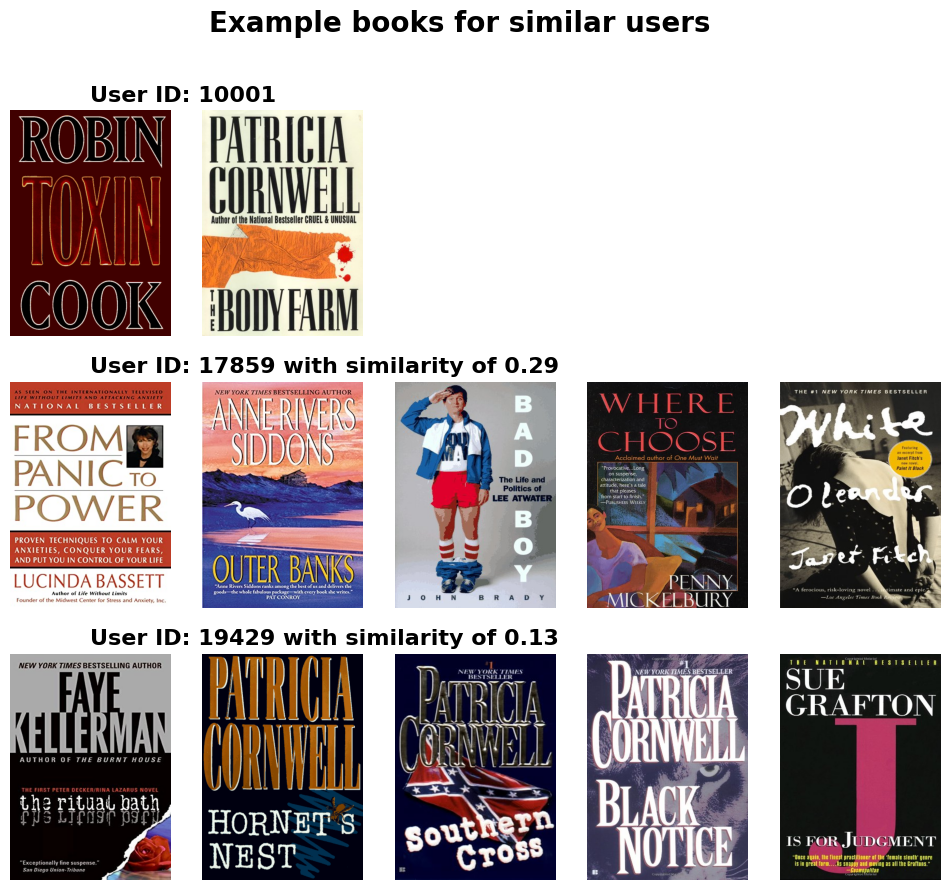

In [98]:
filtered_df = df[df['User-ID'].isin([user_id] + [user_id for user_id, sim in top_users])]
grouped_isbns_by_user = filtered_df.groupby('User-ID')['ISBN'].apply(list)

len_pictures_horizontal = min(max([len(x[1]) for x in grouped_isbns_by_user.items()]), 5)
fig, ax = plt.subplots(len(top_users) + 1, len_pictures_horizontal, figsize=(6 * len(top_users), 10))
fig.suptitle("Example books for similar users", fontweight='bold', fontsize=20)

for i, (user, isbns) in enumerate(grouped_isbns_by_user.items()):
    ax[i, 0].set_title(f"User ID: {user} {f'with similarity of {round(top_users[i - 1][1], 2)}' if i > 0 else ''}", y=1, fontweight='bold', fontsize=16, horizontalalignment='left')
    for j in range(len_pictures_horizontal):
        ax[i, j].axis("off")
        if j >= len(isbns):
            continue
        url = books_df.loc[isbns[j]]["Image-URL-L"]
        img = Image.open(requests.get(url, headers=headers, stream = True).raw)
        ax[i, j].imshow(img, aspect='auto')
        
plt.show()

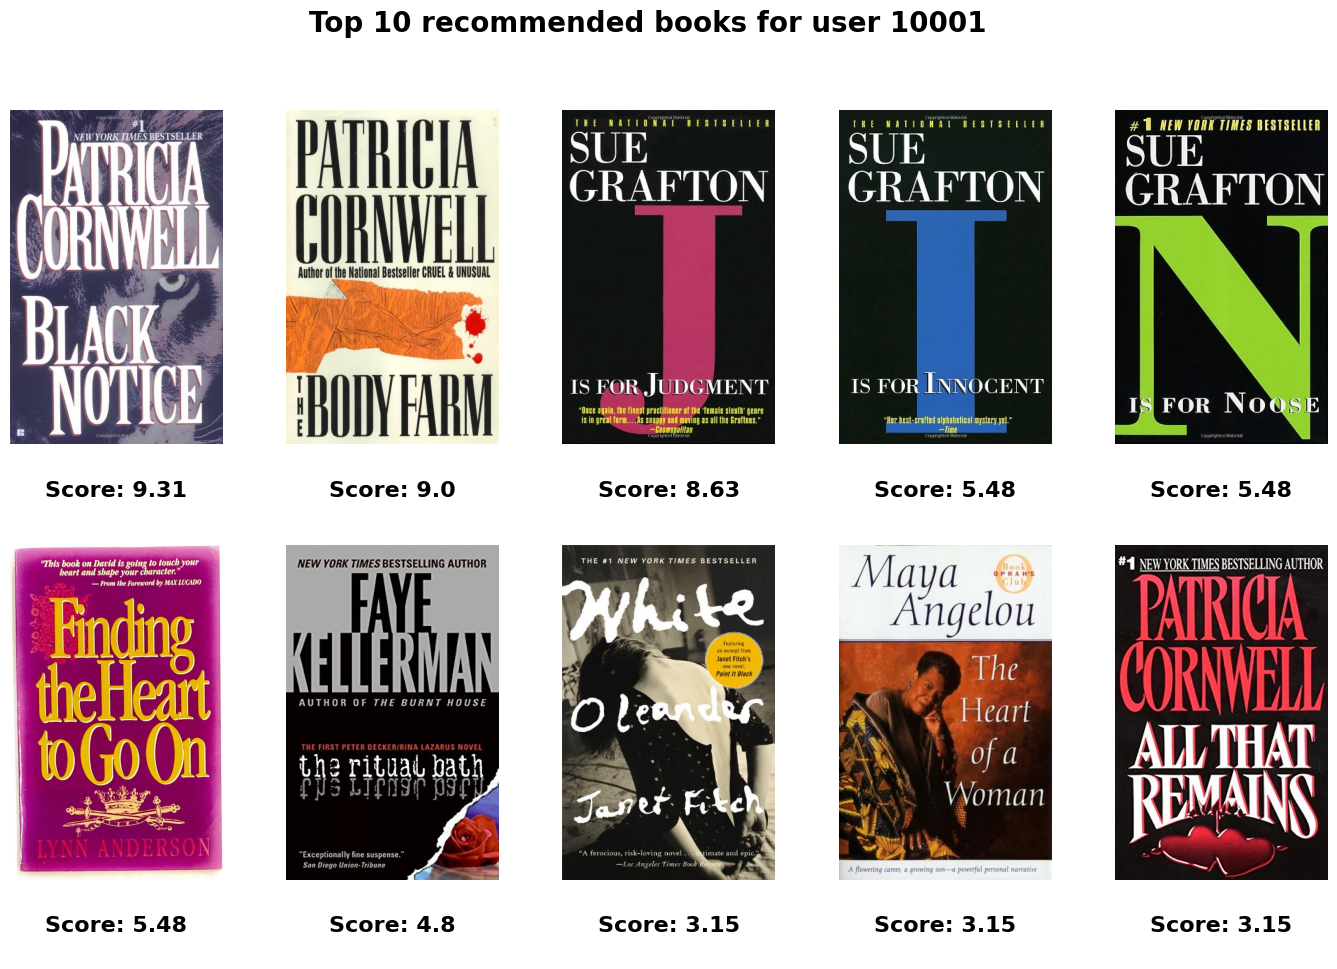

In [99]:
fig, ax = plt.subplots(2, 5, figsize=(17,10))
fig.suptitle(f"Top 10 recommended books for user {user_id}", fontweight='bold', fontsize=20)

for i, (isbn, score) in enumerate(top_isbns):
    url = books_df.loc[isbn]["Image-URL-L"]
    img = Image.open(requests.get(url, headers=headers, stream = True).raw)
    ax[i // 5, i % 5].imshow(img, aspect='auto')
    ax[i // 5, i % 5].axis("off")
    ax[i // 5, i % 5].set_title(f"Score: {round(score, 2)}\n", y=-0.25, fontweight='bold', fontsize=16)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

#### SVD

In [100]:
components = [10, 50, 100, 150, 200, 300]
param_grid = {
    'n_components': components,
}

rmses_and_params = []

# HPO
for params in ParameterGrid(param_grid):
    print(params)
    svd = TruncatedSVD(**params, random_state=0)
    decomposed_matrix = svd.fit_transform(user_item_pivot_matrix_df)
    correlation_matrix = np.corrcoef(decomposed_matrix)
    sorted_similarities_svd = sort_similarities(correlation_matrix)
    rmses_and_params.append((calculate_rmse_for_u_users_for_n_isbns_over_top_k_users(500, 5, 10, sorted_similarities_svd, user_item_pivot_matrix_df), params))
    
best_params = min(rmses_and_params, key=lambda x: x[0])[1]
print(f"Best params: {best_params}")

{'n_components': 10}
{'n_components': 50}
{'n_components': 100}
{'n_components': 150}
{'n_components': 200}
{'n_components': 300}
Best params: {'n_components': 300}


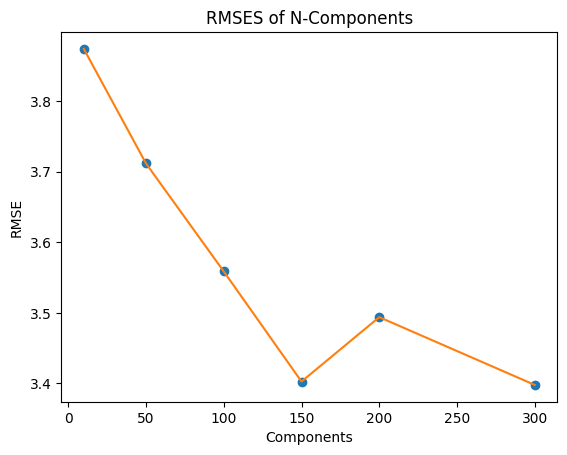

In [103]:
rmses = [x[0] for x in rmses_and_params]
plt.plot(components, rmses, 'o')
plt.plot(components, rmses, '-')
plt.xlabel('Components')
plt.ylabel('RMSE')
plt.title('RMSES of N-Components')
plt.show()

In [104]:
svd = TruncatedSVD(**best_params, random_state=0)
decomposed_matrix = svd.fit_transform(user_item_pivot_matrix_df)
correlation_matrix = np.corrcoef(decomposed_matrix)
sorted_similarities_svd = sort_similarities(correlation_matrix)

In [105]:
user_id = "10001"
top_users, top_isbns = for_user_find_top_n_isbns_and_top_k_similar_users(user_id, 5, 10, sorted_similarities_svd, user_item_pivot_matrix_df)

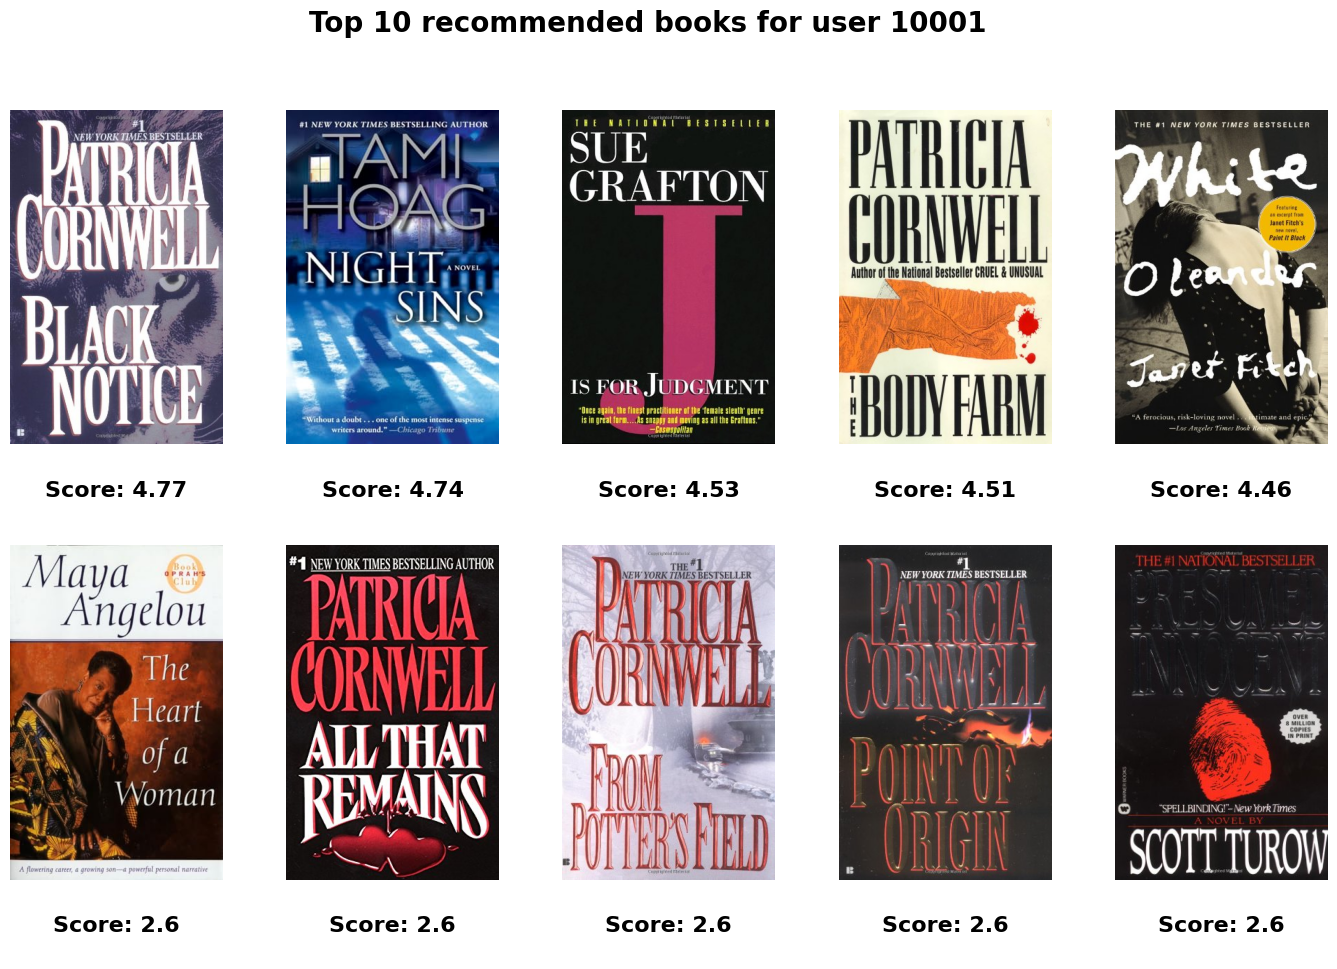

In [106]:
fig, ax = plt.subplots(2, 5, figsize=(17,10))
fig.suptitle(f"Top 10 recommended books for user {user_id}", fontweight='bold', fontsize=20)

for i, (isbn, score) in enumerate(top_isbns):
    url = books_df.loc[isbn]["Image-URL-L"]
    img = Image.open(requests.get(url, headers=headers, stream = True).raw)
    ax[i // 5, i % 5].imshow(img, aspect='auto')
    ax[i // 5, i % 5].axis("off")
    ax[i // 5, i % 5].set_title(f"Score: {round(score, 2)}\n", y=-0.25, fontweight='bold', fontsize=16)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [107]:
# Cosine vs SVD
cosine_rmse = calculate_rmse_for_u_users_for_n_isbns_over_top_k_users(1000, 5, 10, sorted_similarities_cos, user_item_pivot_matrix_df)
svd_rmse = calculate_rmse_for_u_users_for_n_isbns_over_top_k_users(1000, 5, 10, sorted_similarities_svd, user_item_pivot_matrix_df)
print(f"Cosine-RMSE: {cosine_rmse}\nSVD-RMSE: {svd_rmse}")

Cosine-RMSE: 2.4353247351018905
SVD-RMSE: 3.3063086250653555


### NMF

In [25]:
def calculate_rmse(true, predicted):
    predicted = predicted[true.nonzero()].flatten()
    true = true[true.nonzero()].flatten()
    return np.sqrt(mean_squared_error(true, predicted))

param_grid = {
    'n_components': [10, 100, 200],
    'l1_ratio': [0.05, 0.1, 0.2, 0.4]
}

rmses_and_params = []

# HPO
for params in ParameterGrid(param_grid):
    print(params)
    nmf = NMF(**params, init='random', random_state=0)
    w = nmf.fit_transform(user_item_pivot_matrix_df)
    h = nmf.components_
    
    approx_matrix = np.dot(w, h)
    approx_matrix[approx_matrix > 10] = 10       
    approx_matrix[approx_matrix < 0] = 0

    val_rmse = calculate_rmse(user_item_pivot_matrix_df.values, approx_matrix)
    rmses_and_params.append((val_rmse, params))
    
best_params = min(rmses_and_params, key=lambda x: x[0])[1]
print(f"Best params: {best_params}")

{'l1_ratio': 0.05, 'n_components': 10}
{'l1_ratio': 0.05, 'n_components': 100}
{'l1_ratio': 0.05, 'n_components': 200}
{'l1_ratio': 0.1, 'n_components': 10}
{'l1_ratio': 0.1, 'n_components': 100}
{'l1_ratio': 0.1, 'n_components': 200}
{'l1_ratio': 0.2, 'n_components': 10}
{'l1_ratio': 0.2, 'n_components': 100}
{'l1_ratio': 0.2, 'n_components': 200}
{'l1_ratio': 0.4, 'n_components': 10}
{'l1_ratio': 0.4, 'n_components': 100}
{'l1_ratio': 0.4, 'n_components': 200}
Best params: {'l1_ratio': 0.05, 'n_components': 200}


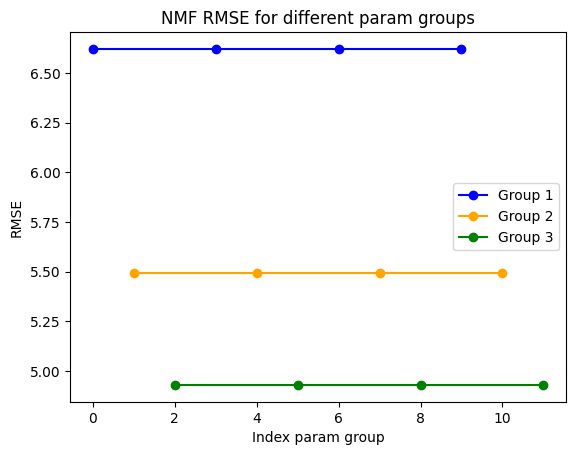

In [26]:
indicies = list(range(0, len(rmses_and_params)))
rmses = [x[0] for x in rmses_and_params]
colors = ['blue', 'orange', 'green']
for i in range(0, 3):
    plt.plot(indicies[i::3], rmses[i::3], 'o-', color=colors[i], label=f'Group {i+1}')
plt.xlabel('Index param group')
plt.ylabel('RMSE')
plt.title('NMF RMSE for different param groups')
plt.legend()
plt.show()

In [27]:
nmf = NMF(**params, init='random', random_state=0)
w = nmf.fit_transform(user_item_pivot_matrix_df)
h = nmf.components_

approx_matrix = np.dot(w, h)
approx_matrix[approx_matrix > 10] = 10
approx_matrix[approx_matrix < 0] = 0

In [28]:
user_id = "10001"
try:
    user_row = user_item_pivot_matrix_df.index.get_loc(user_id)
except:
    raise Exception("User ID doesn't exist.")

sorted_indices = np.argsort(approx_matrix[user_row])[::-1]
sorted_values = approx_matrix[user_row][sorted_indices]
sorted_predictions = list(zip(sorted_indices, sorted_values))[:10]

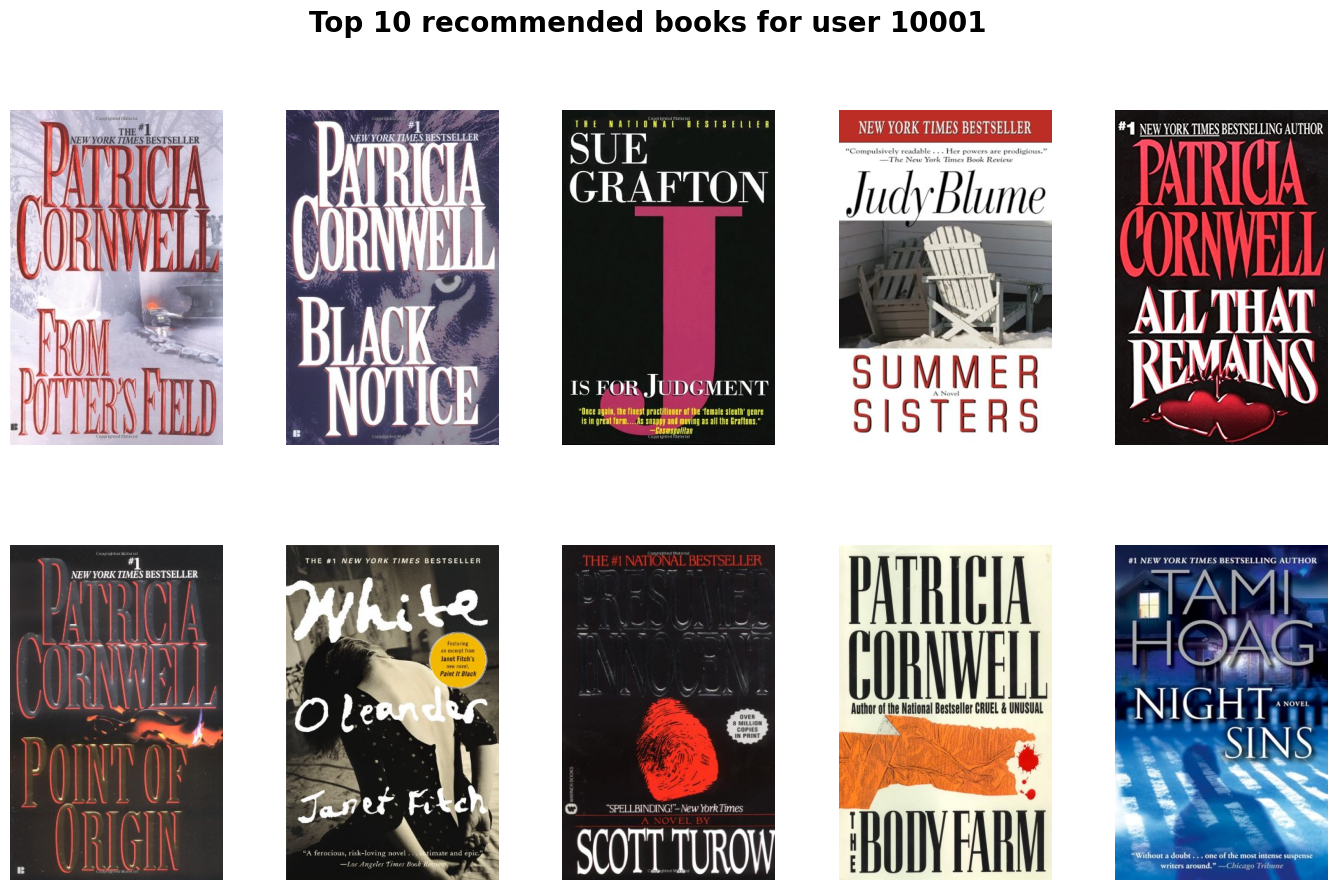

In [34]:
fig, ax = plt.subplots(2, 5, figsize=(17,10))
fig.suptitle(f"Top 10 recommended books for user {user_id}", fontweight='bold', fontsize=20)

for i, (isbn_row, score) in enumerate(sorted_predictions):
    isbn = user_item_pivot_matrix_df.iloc[:, isbn_row].name
    url = books_df.loc[isbn]["Image-URL-L"]
    img = Image.open(requests.get(url, headers=headers, stream = True).raw)
    ax[i // 5, i % 5].imshow(img, aspect='auto')
    ax[i // 5, i % 5].axis("off")

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

## Challenges and improvements
- Performance Metrics:
  - Cosine Similarity - RMSE: 2.44
  - SVD - RMSE: 3.31
  - NMF - RMSE: 4.94  
- Handling large datasets 
- Evaluating SVD, NMF, Cosine Similarity: Limitations of RMSE as a performance metric
- Implementing HPO for SVD and NMF: 
  - Poor performance with high component counts
  - 1000 Components ~30min  
- User data Clustering: Leveraging Geographic Data (Geopy) and Applying Models like Autoencoders